# Abstract

This blog post explores the design, impact, and performance of automated decision-making systems in the context of credit risk evaluation. Using a real-world dataset of loan applicants, we perform exploratory data analysis to understand demographic patterns and loan behavior across age, income, and homeownership groups. We apply logistic regression to predict loan default risk and evaluate model performance using classification metrics and profit-based threshold optimization. Our findings highlight both the predictive strengths and limitations of simple models like logistic regression, particularly in handling class imbalance. We further examine the trade-offs between loan approval and profit maximization, offering insights into how automated decision systems can influence financial access and institutional outcomes.


Access the training data

In [7]:
import pandas as pd
url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/credit-risk/train.csv"
df_train = pd.read_csv(url)
df_train.dropna()


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
1,27,98000,RENT,3.0,EDUCATION,C,11750,13.47,0,0.12,Y,6
2,22,36996,RENT,5.0,EDUCATION,A,10000,7.51,0,0.27,N,4
3,24,26000,RENT,2.0,MEDICAL,C,1325,12.87,1,0.05,N,4
4,29,53004,MORTGAGE,2.0,HOMEIMPROVEMENT,A,15000,9.63,0,0.28,N,10
6,21,21700,RENT,2.0,HOMEIMPROVEMENT,D,5500,14.91,1,0.25,N,2
...,...,...,...,...,...,...,...,...,...,...,...,...
26059,36,150000,MORTGAGE,8.0,EDUCATION,A,3000,7.29,0,0.02,N,17
26060,23,48000,RENT,1.0,VENTURE,A,4325,5.42,0,0.09,N,4
26061,22,60000,RENT,0.0,MEDICAL,B,15000,11.71,0,0.25,N,4
26062,30,144000,MORTGAGE,12.0,PERSONAL,C,35000,12.68,0,0.24,N,8


# Part B:

## Figure 1

The code below performs a data analysis and visualization task focused on loan intent distribution across various age groups and types of homeownership. We first filters the data by selecting only relevant columns (person_age, person_home_ownership, and loan_intent) from the df_train DataFrame, while excludeing any records where the person_home_ownership is labeled as "OTHER". Next, we creates a new column, age_group, by dividing the person_age into predefined age bins (18-24, 25-34, etc.) using the pd.cut() function, which categorizes the individuals into different age ranges. The code then groups the data by age_group, person_home_ownership, and loan_intent, calculating the count of applicants for each combination. Finally, it creates a series of bar plots with the x-axis representing age groups, the y-axis representing the count of applicants, and the hue denoting the loan intent. The plots are further divided by the type of homeownership (e.g., "OWN" or "RENT"), allowing for a comparative visualization across different ownership types.

/var/folders/97/pjhs17cj6y5b0m1x31sjmszh0000gn/T/ipykernel_5824/1813685786.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_1.groupby(


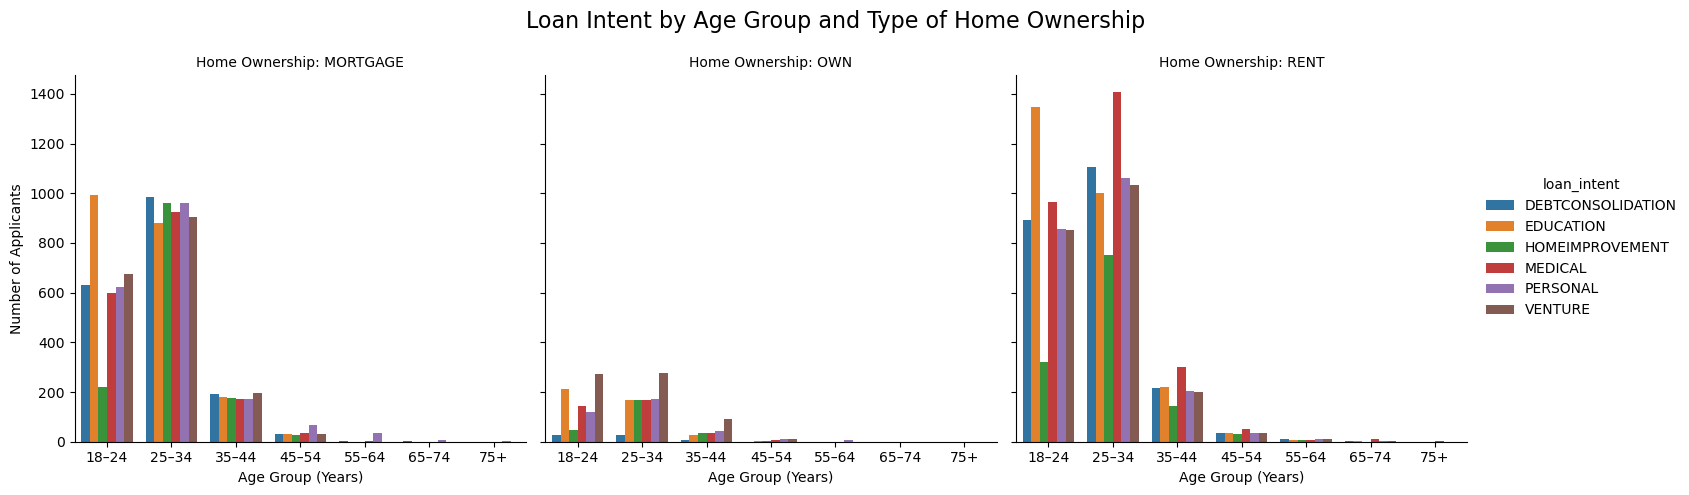

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

df_1 = df_train[["person_age", "person_home_ownership", "loan_intent"]]
df_1 = df_1[df_1["person_home_ownership"] != "OTHER"]
bins = [18, 25, 35, 45, 55, 65, 75, 100]
labels = ['18–24', '25–34', '35–44', '45–54', '55–64', '65–74', '75+']
df_1['age_group'] = pd.cut(df_1['person_age'], bins=bins, labels=labels, right=False)

grouped = df_1.groupby(
    ['age_group', 'person_home_ownership', 'loan_intent']
    ).size().reset_index(name='count')

fig_1 = sns.catplot(
    data=grouped,
    x="age_group",
    y="count",
    hue="loan_intent",
    col="person_home_ownership",
    kind="bar"
)

fig_1.set_axis_labels("Age Group (Years)", "Number of Applicants")
fig_1.set_titles("Home Ownership: {col_name}")
fig_1.fig.suptitle('Loan Intent by Age Group and Type of Home Ownership', fontsize=16)
fig_1.fig.subplots_adjust(top=0.85)

plt.show()


The output of the visualizations presents the distribution of loan intent by age group and homeownership type. From the plots, we can observe clear patterns regarding loan intent preferences within each age group. For instance, there are fewever number of loan applicantions from those who do own a home and across all age groups there is a higher tendency for these to be for venture. Younger individuals in the 18–24 age group tend to show a higher intent for education regardless of home ownership status but we do observe that those who do own a home lean slighly towar venture loans. Those in the 25–34 age group show more balanced intentions between all types of loans when they are paying their mortgage or owning with slightly higher loand applications in venture if they do own. For those > 25 years old who are renting, more applications tend to be for medical bills with the least for home improvement. 


## Figure 2

The code begins by displaying the maximum and minimum values of the loan_int_rate column, which is used to understand the range of loan interest rates in the dataset. The loan_int_rate values are then categorized into predefined bins, ranging from 5% to 23.9%. Each bin represents a specific range of interest rates, such as 5-5.9%, 6-6.9%, etc. The pd.cut() function is used to create these bins and label them with meaningful ranges. Following this, the code computes aggregated statistics for each bin, specifically the mean and median values of two other variables: cb_person_cred_hist_length (credit history length) and loan_percent_income (income percentage). These statistics provide insights into how credit history and income change as the loan interest rate increases, which could reveal underlying patterns or correlations in the dataset.

In [9]:
print("Max Value:", df_train['loan_int_rate'].max())
print("Min Value:", df_train['loan_int_rate'].min())

bins = list(range(5, 25))
labels = [f"{i}-{i+0.9}" for i in bins[:-1]] 
df_train['int_rate'] = pd.cut(df_train['loan_int_rate'], bins=bins, labels=labels, right=False)

df_train.groupby('int_rate').agg(
    mean_cred_hist_length=('cb_person_cred_hist_length', 'mean'),
    median_cred_hist_length=('cb_person_cred_hist_length', 'median'),
    mean_percent_income=('loan_percent_income', 'mean'),
    median_income=('loan_percent_income', 'median')
)


Max Value: 23.22
Min Value: 5.42


/var/folders/97/pjhs17cj6y5b0m1x31sjmszh0000gn/T/ipykernel_5824/4186742674.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_train.groupby('int_rate').agg(


,mean_cred_hist_length,median_cred_hist_length,mean_percent_income,median_income
int_rate,,,,
5-5.9,5.519231,4.0,0.134936,0.110
6-6.9,5.740470,4.0,0.155953,0.130
7-7.9,5.767098,4.0,0.157283,0.130
8-8.9,5.792246,4.0,0.163628,0.140
9-9.9,5.861830,4.0,0.165356,0.140
10-10.9,5.669600,4.0,0.176271,0.150
11-11.9,5.766530,4.0,0.170990,0.150
12-12.9,5.809459,4.0,0.178317,0.160
13-13.9,5.862788,4.0,0.173296,0.160


Looking at the output table, we observe some distinct trends. The mean credit history length remains quite consistent across most of the interest rate bins, hovering around 5.7 years. However, the median credit history length stays constant at 4 years for the majority of the bins, with a noticeable exception at the higher interest rate bins, such as 18-18.9% where it increases to 6 years. For the loan_percent_income variable, we see that as the interest rate increases, the average percentage of income dedicated to loan payments tends to rise slightly, suggesting that individuals with higher loan interest rates may be allocating a greater portion of their income to servicing the loan. The median income percentage also reflects this trend, showing higher values for higher interest rate bins. In particular, the highest interest rate bin (23-23.9%) stands out with a sharp rise in both average credit history length (12 years) and income percentage (27%), indicating that this group may consist of a specific subset of borrowers with longer credit histories and higher financial obligations.


## Figure 3

The code begins by creating a subset of the original dataset (df_3) that includes the variables 'person_income', 'loan_amnt', 'person_emp_length', and 'cb_person_default_on_file'. The next step categorizes 'person_income' into predefined income groups, ranging from 0 to 150k, using the pd.cut() function. This allows the income distribution to be analyzed in segments. The code also calculates the loan amount thresholds (the 25th and 75th percentiles) to classify borrowers into 'Low', 'Mid', or 'High' credit access categories based on their loan amount using a custom function (categorize_credit_access). Finally, a sns.catplot is used to visualize the distribution of income levels and credit access, with data split by whether the borrower has a default on file ('cb_person_default_on_file').

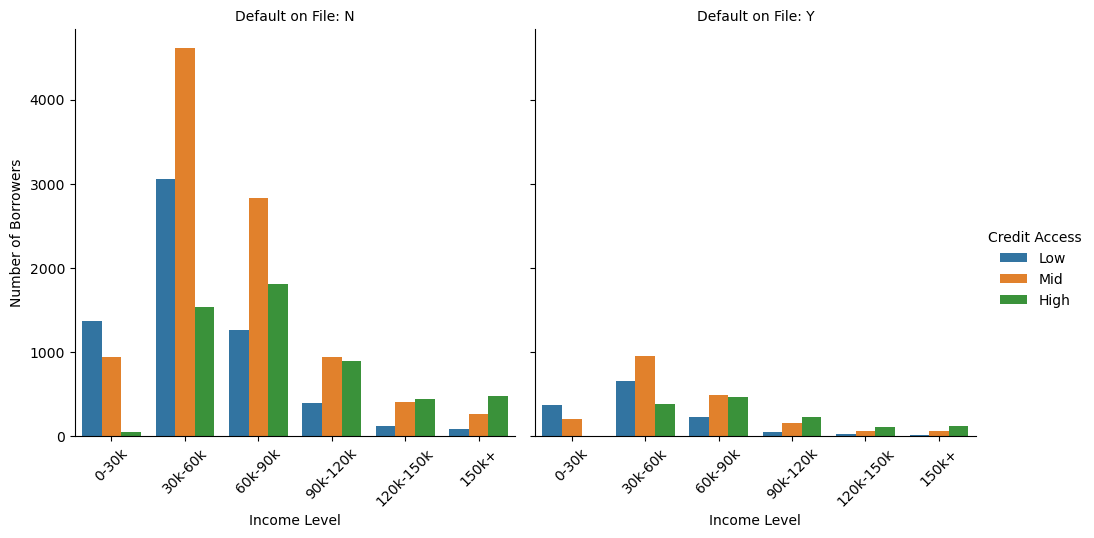

In [10]:
df_3 = df_train[['person_income', 'loan_amnt', 'person_emp_length', 'cb_person_default_on_file']].copy()

bins = [0, 30000, 60000, 90000, 120000, 150000, float('inf')]
labels = ['0-30k', '30k-60k', '60k-90k', '90k-120k', '120k-150k', '150k+']

df_3.loc[:, 'income_level'] = pd.cut(df_3['person_income'], bins=bins, labels=labels, right=False)

low_threshold = df_3['loan_amnt'].quantile(0.25)
high_threshold = df_3['loan_amnt'].quantile(0.75)

def categorize_credit_access(amount):
    if amount <= low_threshold:
        return 'Low'
    elif amount <= high_threshold:
        return 'Mid'
    else:
        return 'High'

df_3.loc[:, 'credit_access'] = df_3['loan_amnt'].apply(categorize_credit_access)

fig_3 = sns.catplot(
    x='income_level',
    hue='credit_access',
    col='cb_person_default_on_file',
    data=df_3,
    kind='count'
)

fig_3.set_titles('Default on File: {col_name}')
fig_3.set_axis_labels('Income Level', 'Number of Borrowers')
fig_3.set_xticklabels(rotation=45)
fig_3._legend.set_title('Credit Access')

plt.show()

The output from Figure 3 provides a detailed breakdown of credit access across different income levels and whether borrowers have a default on file. From the plot, it is apparent that higher income segments, particularly those in the '120k-150k' and '150k+' income categories, tend to have greater access to higher credit lines ('High' credit access) regardless of wether they have defaulted. We also observe that there are fewer applicants regardless of income level that have defaulted on a previous loan. From those applicant who have not defaulted, if they are low-mid income level(30k - 90k) have higher access to mid loan amount than higher loan amounts. As expected we observe that low income applicatnts have little - no access to large loans with some access to medium loan amounts but most access to smaller loans.


# Part C: Logistic Regression

This code implements a binary classification model to predict loan default status (loan_status) using logistic regression. First, a subset of relevant features is selected from the dataset, including demographic and financial attributes such as age, income, loan amount, interest rate, percent income, and credit history length. Any rows with missing values are removed to ensure clean input data. The dataset is then split into features (X) and target labels (y), and further divided into training and test sets using an 80/20 split. Because logistic regression is sensitive to feature scaling, the input features are standardized using StandardScaler. A LogisticRegression model is trained on the scaled training data, and predictions are made on the scaled test set. Finally, the confusion matrix, accuracy, and F1-score are calculated to evaluate the model.

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

df_model = df_train[['person_age', 'person_income', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length', 'loan_status']]
df_model = df_model.dropna()

X = df_model.drop(columns=['loan_status'])
y = df_model['loan_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression()
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Confusion Matrix:")
print(conf_matrix)
print(f"Accuracy: {accuracy:.4f}")
print(f"F1-Score: {f1:.4f}")


Confusion Matrix:
[[3521  212]
 [ 590  391]]
Accuracy: 0.8299
F1-Score: 0.4937


The confusion matrix and associated metrics provide insight into the model’s performance. The matrix shows that the model correctly predicted 3,521 non-default cases and 391 default cases, but it also made 212 false positive and 590 false negative errors. The accuracy of approximately 82.99% indicates that the model performs well overall in classifying both outcomes. However, the F1-score of 0.4937 suggests a significant imbalance in how well the model identifies defaulting borrowers. While the model is good at identifying non-defaults, its relatively low F1-score indicates weaker performance in detecting actual defaults, which are often the minority class in such datasets. This highlights the need for further tuning or exploring alternative models to improve performance on the minority class.


# Part D: Threshold

This following code block evaluates different classification thresholds to find the one that maximizes expected profit per prospective borrower, based on the logistic regression model's probability outputs. Two functions define potential profits: profit_if_repaid calculates the return from a borrower who repays the loan over 10 periods, while profit_if_default estimates the loss-adjusted return when a borrower defaults after 3 periods, accounting for a 70% loss on the loan principal. The model’s predicted probabilities (y_proba) of loan default are obtained, and a range of 100 threshold values between 0 and 1 is tested. For each threshold, a prediction is made: if the probability exceeds the threshold, the borrower is rejected since there is a high likelihood that they will default(coded as 1), and otherwise, the borrower is approved as they are very likely to repay the loan(coded as 0). The profit is then computed only for those approved (predicted 0), based on their actual loan status: if the borrower truly repaid (label 0), the profit_if_repaid function is used; if they defaulted (label 0), profit_if_default is applied. The average profit per borrower at each threshold is stored and plotted, allowing us to identif the most profitable decision boundary.

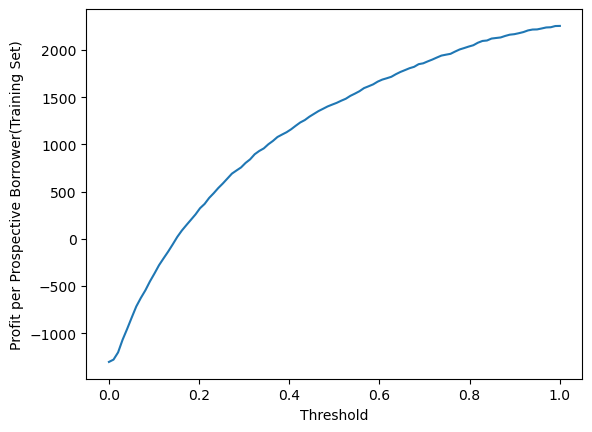

Best threshold for max profit: 1.00


In [12]:
import numpy as np

def profit_if_repaid(loan_amnt, loan_int_rate):
    loan_int_rate = loan_int_rate / 100  # Convert to decimal based on feedback
    return loan_amnt*(1 + 0.25*loan_int_rate)**10 - loan_amnt

def profit_if_default(loan_amnt, loan_int_rate):
    loan_int_rate = loan_int_rate / 100  # Convert to decimal based on feedback
    return loan_amnt*(1 + 0.25*loan_int_rate)**3 - 1.7*loan_amnt

y_proba = model.predict_proba(X_test_scaled)[:, 1]

# Changes based on feedback:
loan_amnt_arr = X_test['loan_amnt'].values
loan_rate_arr = X_test['loan_int_rate'].values
actual_status = y_test.values

repaid_profits = profit_if_repaid(loan_amnt_arr, loan_rate_arr)
defaulted_profits = profit_if_default(loan_amnt_arr, loan_rate_arr)

thresholds = np.linspace(0, 1, 100)
profits = []

for t in thresholds:
    # vectorized methods rather than relying on a for-loop across data rows. 
    predictions = (y_proba > t).astype(int)
    repaid_condition = (actual_status == 0) & (predictions == 0)
    defaulted_condition = (actual_status == 1) & (predictions == 1)

    total_profit = (
        np.sum(repaid_profits[repaid_condition]) +
        np.sum(defaulted_profits[defaulted_condition])
    )
    
    avg_profit = total_profit / len(y_test)
    profits.append(avg_profit)

plt.plot(thresholds, profits)
plt.xlabel("Threshold")
plt.ylabel("Profit per Prospective Borrower(Training Set)")
plt.show()

best_threshold = thresholds[np.argmax(profits)]
print(f"Best threshold for max profit: {best_threshold:.2f}")

final_predictions = (y_proba > best_threshold).astype(int)

The analysis reveals that the most profitable threshold for approving loans is 1.00, meaning the model should approve applicants with a predicted probability of default lower than 1.00. This threshold represents an extremely conservative approach, maximizing profit by approving only those with the lowest likelihood of default. However, this comes at the cost of a very narrow approval rate. By setting the threshold at 1.00, the model optimizes the trade-off by approving only the most reliable applicants, thus minimizing the risk of defaults and ensuring that the potential gains from repaid loans significantly outweigh the losses from defaults. The profit curve illustrates how expected profit changes across thresholds, showing that the profit per prospective borrower increases sharply up to a threshold value of 1.00 but then remains relatively constant. This reinforces the trade-off between loan approval rates and risk exposure and emphasizes that, at this high threshold, the approval rate becomes severely limited, and the risk of excluding potential borrowers increases significantly.

# Discussion

The analysis presented in this blog uncovers several key insights about the relationship between borrower demographics and credit access, as well as the performance and implications of predictive modeling in financial decision-making.

Our initial visualizations show clear disparities in loan intent across age and homeownership status. Younger individuals, especially renters, tend to apply for education-related loans, while older age groups and homeowners exhibit broader loan purposes. Interest rate analysis (Figure 2) reveals a positive correlation between loan interest and borrower risk, as measured by loan percent income and credit history. High-interest borrowers tend to allocate a greater portion of their income to loan repayment and may have longer (or more extreme) credit histories. Additionally, Figure 3 shows that high-income individuals, regardless of prior default status, have better access to large loans—suggesting that income remains a dominant factor in credit access even when defaults are present.

The logistic regression model achieves high overall accuracy (82.99%) but struggles to correctly classify default cases, as indicated by an F1-score of 0.4937. This underperformance on the minority class is a common issue in credit risk modeling and raises concerns about the fairness and robustness of simple binary classifiers. The model’s bias toward predicting non-defaults can lead to missed opportunities for targeted interventions or overestimation of repayment reliability.

By applying a profit-based threshold selection (Part D), we found that the most financially optimal strategy is to approve only those applicants with an extremely low predicted probability of default (threshold = 1.00). While this maximizes average profit per borrower, it comes at the cost of possibly denying nearly all applicants. This result highlight a critical trade-off between maximizing institutional profit and borrower access. It also highlights the ethical complexity of using automated systems in high-stakes domains such as lending, where capitalistic thresholds may further social and economic exclusion as we have seen in other instances throughout class.

This analysis demonstrates the power and pitfalls of automated credit decision systems. While models like logistic regression can support scalable and data-driven decisions, their performance and the interpretation of results must be carefully managed. Especially important is the role of domain-specific metrics (e.g., profit, fairness) in shaping model thresholds and deployment strategies. As such systems increasingly mediate access to essential financial resources, their design should be critically examined for both technical performance and broader societal impact.

